In [1]:
!pip install matplotlib numpy qutip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.1/30.1 MB 33.9 MB/s eta 0:00:00


100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.04s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.08s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.06s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.06s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.06s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.04s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.06s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.06s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.09s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.05s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.02s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.03s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:

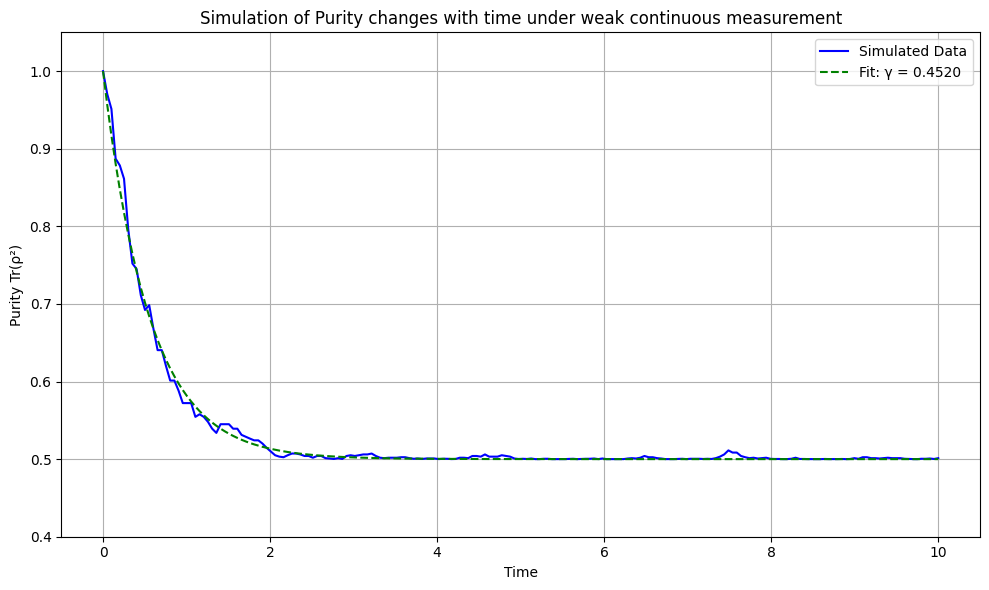

In [5]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from qutip import *


# simulation parameters
gamma = 0.5              #dephasing (measurement) strength
T = 10.0                 #simulation time
steps = 200              #no of time steps
ntraj = 200              #no of trajectories


# initial qubit state: |+> = (|0> + |1>)/sqrt(2)
psi0 = (basis(2, 0) + basis(2, 1)).unit()


# no hamiltonian evolution (only decoherence)
H = 0 * sigmaz()


# collapse operator for dephasing (simulating continuous measurement)
c_ops = [np.sqrt(gamma) * sigmaz()]


# time grid
times = np.linspace(0, T, steps)


# initialising density matrices
density_matrices = [Qobj(np.zeros((2, 2), dtype=complex), dims=[[2], [2]]) for _ in times]


# running each trajectory averaging to find density matrices
for _ in range(ntraj):
    result = mcsolve(H, psi0, times, c_ops, e_ops=[], ntraj=1, options=Options(store_states=True))
    for i, state in enumerate(result.states):
        rho = state * state.dag()
        density_matrices[i] += rho


#working out the purity from the density matrix
purities = []
for rho in density_matrices:
    rho_avg = rho / ntraj
    purity = (rho_avg * rho_avg).tr().real
    purities.append(purity)


#creating the exponential fit
def purity_model(t, gamma_fit):
    return 0.5 * (1 + np.exp(-4 * gamma_fit * t))
popt, pcov = curve_fit(purity_model, times, purities, p0=[0.1])
gamma_fit = popt[0]
gamma_fit_err = np.sqrt(np.diag(pcov))[0]


print(f"Fitted gamma: {gamma_fit:.4f} ± {gamma_fit_err:.4f}")
print(f"True gamma:   {gamma}")


#exponential fit curve
fitted_purities = purity_model(times, gamma_fit)


# plotting
plt.figure(figsize=(10, 6))
plt.plot(times, purities, 'b-', label='Simulated Data')
plt.plot(times, fitted_purities, 'g--', label=f'Fit: γ = {gamma_fit:.4f}')
plt.xlabel("Time")
plt.ylabel("Purity Tr(ρ²)")
plt.title("Simulation of Purity changes with time under weak continuous measurement")
plt.legend()
plt.grid(True)
plt.ylim(0.4, 1.05)
plt.tight_layout()
plt.show()